You can view this notebook in Google Colab by clicking on [this link](https://colab.research.google.com/drive/1886s3v5XGc-pGe_alRfHq9NA5knCLLSB?usp=sharing). (Some of Latex expressions can't be displayed out of Google Colab)

# Decision trees 

A decision tree is a very simple machine learning model. 
It was widely used in the 1960's-1980's to build expert systems. 
It is widely known and used in many companies to facilitate the decision making process and risk analysis. 

Given several characteristics, the decision is started with one of these characteristics; if this is not enough, another one is used, and so on. 
The rules are introduced manually, for this reason this model lost its popularity after the 80s. The appearance of mathematical methods to build decision trees brings this model back to the battle of machine learning algorithms.
There are several automatic algorithms to build decision trees:

* ID3 (Iterative Dichotomiser 3): developed in 1986 by Ross Quinlan. It can be applied only on nominal features. It is used for classification.
* C4.5: an extension of ID3 by Ross Quinlan. It can be applied on all types of characteristics. It is used for grading.
* C5.0: a commercial extension of C4.5, again by Ross Quinlan.
* CART (Classification and Regression Trees): like C4.5 but uses other metrics. Also, the algorithm supports regression.

The general algorithm for creating a decision tree :

* Determine the best feature in the training data set.
* Divide the training data into subsets containing the possible values of the best feature.
* Recursively generate new decision trees using the subsets of data created.
* When you can no longer classify the data, you stop.

## Advantages 

* They are simple to understand and interpret. You can visualize the trees. Also, the results obtained can be easily explained.
* They can work on data with little preparation. For example, they do not need data normalization.
* They accept both numerical and nominal data. Other learning algorithms are specialized in one type of data.
* They perform well even if their assumptions are violated by the real model from which the data was generated.

## Limitations

* They can be so complex, they do not generalize well (overfitting). This can be fixed by setting the minimum number of samples in the leaves or by setting the maximum depth of the tree.
* They can be unstable because of data variations.
* There are some concepts that are a bit difficult to learn from decision trees. They are not easy to express, for example: XOR.
* They can be biased to the dominant class. So, you have to balance the data before training the system.
* It is not guaranteed that the optimal decision tree will be found.

## Download the datasets

In [3]:
! mkdir datasets
! wget -c "https://drive.google.com/uc?export=download&id=1XAlljqou6yuG6JgoeFsOl0R99HFBipBy" -O datasets/jouer.csv
! wget -c "https://drive.google.com/uc?export=download&id=1ZrcD9c7jcR8KWKJQCMSKTsh1E6mmwN4L" -O datasets/jouer_num.csv
! wget -c "https://drive.google.com/uc?export=download&id=165-GKyfxEB6FsyZGjn4Qz-80ZMRp-KFy" -O datasets/iris.csv

--2021-11-26 22:33:54--  https://drive.google.com/uc?export=download&id=1XAlljqou6yuG6JgoeFsOl0R99HFBipBy
Resolving drive.google.com (drive.google.com)... 172.217.2.110, 2607:f8b0:4004:80a::200e
Connecting to drive.google.com (drive.google.com)|172.217.2.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-8o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t41bn2nsc8kisdu9fdc4pmnl33m7tc3l/1637966025000/02428432253297012158/*/1XAlljqou6yuG6JgoeFsOl0R99HFBipBy?e=download [following]
--2021-11-26 22:33:54--  https://doc-10-8o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t41bn2nsc8kisdu9fdc4pmnl33m7tc3l/1637966025000/02428432253297012158/*/1XAlljqou6yuG6JgoeFsOl0R99HFBipBy?e=download
Resolving doc-10-8o-docs.googleusercontent.com (doc-10-8o-docs.googleusercontent.com)... 142.251.45.97, 2607:f8b0:4004:83f::2001
Connecting to doc-10-8o-docs.googleusercontent.com (doc-10-8o-docs.goo

## I- ID3 (Implementation)

The algorithm works only on nominal characteristics. 
So, if we have continuous features, we have to apply the discretization. 
Also, it is used for ranking only (no regression).


### I-1- Reading and preparation of the test data


In [4]:
import numpy as np
import pandas as pd 


jouer = pd.read_csv("datasets/jouer.csv")
jouer

,temps,temperature,humidite,vent,jouer
0,ensoleile,chaude,haute,non,non
1,ensoleile,chaude,haute,oui,non
2,nuageux,chaude,haute,non,oui
3,pluvieux,douce,haute,non,oui
4,pluvieux,fraiche,normale,non,oui
5,pluvieux,fraiche,normale,oui,non
6,nuageux,fraiche,normale,oui,oui
7,ensoleile,douce,haute,non,non
8,ensoleile,fraiche,normale,non,oui
9,pluvieux,douce,normale,non,oui


In [5]:
X_jouer = jouer.iloc[:, :-1].values # First columns 
Y_jouer = jouer.iloc[:,-1].values # Last columns

X_jouer[:3, :]

array([['ensoleile', 'chaude', 'haute', 'non'],
       ['ensoleile', 'chaude', 'haute', 'oui'],
       ['nuageux', 'chaude', 'haute', 'non']], dtype=object)

### I-2- Probability 

Given a set of values $S$ (in python: array), the probability of occurrence of a value $v$ (a string) is the number of occurrences of $v$ in $S$ divided by the total number of elements in $S$. 

$$p(v/S) = \frac{|\{x / x \in S \text{ et } x = v\}|}{|S|}$$

For example, let's take the "play" column. 
The number of "yes" is 9 and the total number is 14. 
$$p(jouer=yes) = \frac{9}{14} = 0.6428571428571429$$

In [6]:
# Compute the probability of occurrence of a value val in a set S
# S is a string vector (array)
def P (S, val): 
    return float(np.count_nonzero(S==val))/len(S)


# Manual calculation 5 digits after the decimal point (without rounding)
# P(jouer=oui) = 9/14 = 0.64285
# P(temps = ensoleilé) = 5/14 = 0.35714
# P(temps = nuageux) = 4/14 = 0.28571
# P(temps = pluvieux) = 5/14 = 0.35714


P(Y_jouer, "oui"), P(X_jouer[:,0], "ensoleile"), P(X_jouer[:, 0], "nuageux"), P(X_jouer[:,0], "pluvieux")

(0.6428571428571429,
 0.35714285714285715,
 0.2857142857142857,
 0.35714285714285715)

### I-3- Uncertainty of a set

Shannon's entropy is the amount of information contained in a source of information; the more different information the source emits, the greater the entropy (or uncertainty about what the source emits).
Therefore, a set with an entropy of 0 contains the same values.
Given : 
- $S$ a set of values 
- $V$ a set of unique values of $S$ 

The entropy of $S$ is calculated as follows: 
$$H(S) = - \sum\limits_{v \in V} p(v/S) \log_2 p(v/S)$$

For example, the column "joeur" contains two values "oui" and "non". 
Its entopy is :
$$H(jouer) = - \frac{9}{14} * \log_2(\frac{9}{14}) - \frac{5}{14} * \log_2(\frac{5}{14}) = 0.9402859586706309$$

In [7]:
# The entropy function
import math as mth
def H(S):  
    vals = np.unique(S)
    res = 0
    for val in vals:
        res -= P(S,val)*mth.log(P(S,val),2)
    return res 

# Manual calculation 5 digits after the decimal point (without rounding)
# H(temps) = - P(temps = ensoleilé) * log2 (P(temps = ensoleilé))
#            - P(temps = nuageux) * log2 (P(temps = nuageux))
#            - P(temps = pluvieux) * log2 (P(temps = pluvieux))
#          = - 5/14 * log2(5/14) - 4/14 * log2(4/14) - 5/14 * log2(5/14)
#          = 1.57740 (copier-coller la formule dans Google)

H(X_jouer[:,0])

1.5774062828523452

### I-4- Division of a set

Here, we try to divide the set of classes according to the values of an attribute (characteristic, column) to subsets. 

Given : 
- S: the set to be divided (a vector in reality, since we must use the order of the elements)
- A: the set of values of an attribute (characteristic, column). It is a vector aligned with S; i.e., each element of A has a respective element of S.
- val : the value on which we divide.

$$S_{A, val} = \{v_i \in S / i \in \{j / w_j \in A \text{ et } w_j = val\}\}$$

For example, if 
- $S$ is the set of "jouer" classes
- $A$ is the set of characteristic values "time
- $val$ is the value "ensoleile"
The subset of "jouer" where (time = "ensoleile") contains 3 no and 2 yes 

In [8]:
# The function must return a subset of S
# where the respective values in A are equal to val
def diviser(S, A, val):
    msk = A == val
    return S[msk]


diviser(Y_jouer, X_jouer[:,0], "ensoleile")

array(['non', 'non', 'non', 'oui', 'oui'], dtype=object)

Maintenant, on divise la colonne "jouer" (Y_jouer) sur trois sous-ensembles selon les valeurs de la colonne "temps". 
Pour chaque sous-ensemble, on calcule l'entropie.

In [9]:
Y_ensoleile = diviser(Y_jouer, X_jouer[:,0], "ensoleile") # jouer: 2 oui, 3 non
# H(S_ensoleilé) = - 2/5 * log2(2/5) - 3/5 * log2(3/5) = 0.9709505944546686
Y_nuageux = diviser(Y_jouer, X_jouer[:,0], "nuageux") # jouer: 4 oui, 0 non
# P(S_nuageux) = - 4/4 * log2(4/4) - 0/4 * log2(0/4) = 0.0
Y_pluvieux = diviser(Y_jouer, X_jouer[:,0], "pluvieux") # jouer: 3 oui, 2 non
# P(S_pluvieux) = - 3/5 * log2(3/5) - 2/5 * log2(2/5) = 0.971

# Résultat: 
# (0.9709505944546686, 0.0, 0.9709505944546686)
H(Y_ensoleile), H(Y_nuageux), H(Y_pluvieux)

(0.9709505944546686, 0.0, 0.9709505944546686)

We notice that the entropy of the set (temps = nuageux) is equal to 0 

- The entropy of the cloudy set is null, it means that this variable is homogeneous, ide, all its values are similar.
- No, we don't need to divide this set, we can take a decision from this level

### I-5- The entropy gain

The entropy gain (information gain) is the difference between the entropy before and after the division of a set $S$ according to the attribute $A$. 
In other words, how much uncertainty in $S$ has been reduced after its division using the attribute $A$.

Given: 
- S: a set (in our case, the set of classes) 
- A: set of values of an attribute (characteristic, column) 
- V : the set of the different values of the attribute A
- p(v/A) : the probability of occurrence of the value $v$ in $A$
- $S_{A, v}$ : subset of $S$ where the values of $V$ are equal to $v$ 

The enterpy gain is computed as follows: 

$$IG(S, A) = H(S) - \sum_{v \in V} p(v/A) H(S_{A, v})$$

In [10]:
# This function must return the entropy gain and the entropy 
# The entropy is returned so as not to recalculate later 
def IG(S, A):
    vals = np.unique(A)
    entropie = H(S)
    ig_global = entropie

    for val in vals:
        ig_global -= P(A,val)*H(diviser(S,A,val))
    return ig_global, entropie

#    TEST
# ===========
# IG(S, temps) = H(S) - P(temps = ensoleilé) * H(S_ensoleilé) - P(temps = nuageux) * H(S_nuageux) - P(temps = pluvieux) * H(S_pluvieux)
#              = 0.2467498197744391

IG(Y_jouer, X_jouer[:, 0])

(0.2467498197744391, 0.9402859586706309)

In [11]:
print("IG(jouer, temps), IG(jouer, température), IG(jouer, humidité), IG(jouer, vent)")

IG(Y_jouer, X_jouer[:, 0]), IG(Y_jouer, X_jouer[:, 1]), IG(Y_jouer, X_jouer[:, 2]), IG(Y_jouer, X_jouer[:, 3])

IG(jouer, temps), IG(jouer, température), IG(jouer, humidité), IG(jouer, vent)


((0.2467498197744391, 0.9402859586706309),
 (0.029222565658954647, 0.9402859586706309),
 (0.15183550136234136, 0.9402859586706309),
 (0.04812703040826932, 0.9402859586706309))

- The characteristic that should be used to divide the first node is the characteristque 0 ( temps ), because it has the greatest gain between the other characteristques.

In [12]:
# This function looks for the most suitable 
# the most adequate to divide Y 
# it must also return the GI and H of this feature 
def num_caracteristique(X, Y): 
    num = -1
    num_ig = - 1.0
    num_h = -1.0
    for i in range(X.shape[1]):
        if IG(Y,X[:,i])[0]>num_ig:
            num = i
            num_ig, num_h = IG(Y,X[:,i])
    return num, num_ig, num_h

num_caracteristique(X_jouer, Y_jouer)

(0, 0.2467498197744391, 0.9402859586706309)

### I-6- Creating the tree

We create a structure for the tree (the Node class)

We implement a recursive function to create a tree from a set

In [14]:
# A class to hold the node information and 
# the list of its children
class Noeud(object): 
    
    nbr = 0
    
    def __init__(self, num, ig, h, profondeur): 
        self.num = num # the number of the division feature in X
        self.ig = ig # the division IG
        self.h = h # the entropy H
        self.pr = profondeur # the depth of the node
        self.fils = {} # fils; a dictionary value : node
        self.cls = "" # the class if this node is final (if there are no children)
        self.indent = " " # indentation when generating the code
    
    # This function is to transform the node to a string
    #Here we have redefined this function so that it writes the tree 
    # in the form of an algorithm; it is a parser 
    def __str__(self):
        
        indent = self.indent * self.pr # indentation : esthetique
        
        # if there are no children, the node is terminal; we print the class
        if (len(self.fils)==0):
            return indent + 'Y est "' + self.cls + '"\n'
        
        # if there are wires, we loop on the wires and print SI ... ALORS
        res = ""
        for valeur in self.fils:
            res += indent + 'Si X[' + str(self.num) + '] est "' + str(valeur) + '" Alors\n' + str(self.fils[valeur])
        return res
    
    # predict a sample
    def predire(self, x): 
        
        # If the node is final, it returns its class 
        if (len(self.fils)==0):
            return self.cls
        
        # If the value of the respective column at this node does not belong to the set of
        # expected values, we return np.nan
        if x[self.num] not in self.fils: 
            return np.nan
        
        # Otherwise, we return 
        return self.fils[x[self.num]].predire(x)
    
    # generate a code for graphviz
    def graphviz(self): 
        
        nid = 'N' + str(Noeud.nbr)
        Noeud.nbr += 1
        
        # If the node is final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        # Otherwise, 
        # if there are wires, we loop on the wires and print SI ... ALORS
        res = nid + '[label="X[' + str(self.num) + ']\\n'
        res += 'H = ' + str(self.h) + '\\n'
        res += 'IG = ' + str(self.ig) + '"];\n'
        for valeur in self.fils:
            vid, code = self.fils[valeur].graphviz()
            res += code
            res += nid + ' -> ' + vid + ' [label="' + valeur + '"];\n'
        return nid, res
    

# create the decision tree from a set X and Y
def entrainer(X, Y, profondeur=0, elagage=False): 
    
    # Find the best characteristic of X to divide Y
    num, num_ig, num_h = num_caracteristique(X, Y)
    # Create a node 
    noeud = Noeud(num, num_ig, num_h, profondeur)
    # If the entropy is 0 then the node is a leaf 
    if num_h == 0.0:
        noeud.cls = Y[0] # the class of the node
        return noeud # return the node 
    
    # there is no pruning in ID3, but it must be activated to avoid 
    # the problem of max recursion 
    if profondeur > 0 and elagage:
        noeud.cls = max(set(Y))
        return noeud # return the node
    
    # Sinon, si le noeud n'est pas une feuille, on crée ces fils
    profondeur += 1 # la profondeur de ces fils
    # les fils sont créés à partir des valeurs uniques du meilleur caractéristique
    for val in np.unique(X[:, num]):
        # Ces trois lignes sont pour récupérer les sous-ensembles X_val, Y_val
        # Corresondants à une valeur du meilleur caractéristique
        msk = X[:, num] == val 
        X_val = X[msk]
        Y_val = Y[msk]
        # On refait la même opération sur l'ensemble (Y_val) d'une manière récursive
        fils = entrainer(X_val, Y_val, profondeur, elagage)
        # On affecte le noeud créé indexé par la valeur du meilleur caractéristique 
        # à l'ensemble des fils du noeud courant
        noeud.fils[val] = fils
    
    return noeud

arbre_jouer = entrainer(X_jouer, Y_jouer)

print("Le Code")
print(arbre_jouer)

# Tester sur un échantillon
arbre_jouer.predire(["pluvieux", "temperature_makanche", "humidite_makanche", "non"])

Le Code
Si X[0] est "ensoleile" Alors
 Si X[2] est "haute" Alors
  Y est "non"
 Si X[2] est "normale" Alors
  Y est "oui"
Si X[0] est "nuageux" Alors
 Y est "oui"
Si X[0] est "pluvieux" Alors
 Si X[3] est "non" Alors
  Y est "oui"
 Si X[3] est "oui" Alors
  Y est "non"



'oui'

### I-7- Grouping functions together*.

In [15]:
class ID3(object): 
    
    def entrainer(self, X, Y, X_noms=[], Y_nom="", elagage=False):
        self.arbre = entrainer(X, Y, elagage=elagage)
        code = str(self.arbre)
        if len(Y_nom) > 0: 
            code = code.replace("Y", Y_nom)
        for i in range(len(X_noms)): 
            code = code.replace("X[" + str(i) + "]", X_noms[i])
        self.code = code
        self.X_noms = X_noms
    
    def predire(self, X): 
        predictions = []
        for i in range(len(X)): 
            predictions.append(self.arbre.predire(X[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.arbre.graphviz()
        res = "digraph Tree {\n"
        res += "node [shape=box] ;"
        for i in range(len(self.X_noms)): 
            code = code.replace("X[" + str(i) + "]", self.X_noms[i])
        res += code
        res += "}"
        return res

id3_classifieur = ID3()
id3_classifieur.entrainer(X_jouer, Y_jouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")
print(id3_classifieur.code)

Si temps est "ensoleile" Alors
 Si humidite est "haute" Alors
  jouer est "non"
 Si humidite est "normale" Alors
  jouer est "oui"
Si temps est "nuageux" Alors
 jouer est "oui"
Si temps est "pluvieux" Alors
 Si vent est "non" Alors
  jouer est "oui"
 Si vent est "oui" Alors
  jouer est "non"



- The attribute does not contribute to the decision, the change of its values does not lead to a change in the decision. We had this situation because, in the training, we arrived at a stop criterion without having used this attribute "Temperature" to separate a node, its gain was always lower than that of the other attributes

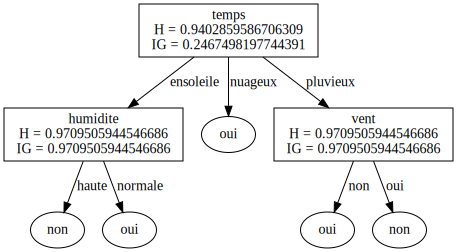

In [16]:
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph = Source(id3_classifieur.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

## II- C4.5 

This algorithm is an improvement on the ID3 algorithm.
Among the improvements:

- Transform continuous (numeric) features into nominal features dynamically.
- Features without values are ignored when calculating entropy and information gain.
- Tree pruning after creation.

### II-1- Selecting the best feature

When we have a feature with a large number of values, it will be favored by the entropy gain (IG). 
C4.5 uses an extension of the GI called "gain ratio".
The gain ratio deals with the bias problem by normalizing the information gain using the division information.


Given: 
- S: a set (in our case, the set of classes) 
- A: the set of values of an attribute (characteristic, column) 
- V : the set of the different values of the attribute A
- p(v) : the probability of occurrence of the value $v$ in $A$
- $S_{A, v}$ : subset of $S$ where the values of $V$ equal $v$ 

The Split Information (SI) can be computed as follows:
$$SI(S, A) = - \sum_{v \in V} p(v) H(S_{A, v})$$

And the Gain Ratio (GR) is calculated as follows:
$$GR(S, A) = \frac{IG(S, A)}{SI(S, A)}$$

### II-2- Handling continuous features

ID3 does not support features with continuous values; like age, price, etc.
C4.5 introduces the support of this kind of features by looking for the best threshold that can divide the set of values of a feature in two.

In order to select the right division, we follow the following algorithm each time we want to compare a feature with others:

- For each $v_{A,i}$ value of a feature $A$ 
    - Divide the data set $S$ into two subsets: the data with $ v > v_{A,i}$ and the data with $ v <= v_{A,i}$
    - Compute the gain ratio GR of this division
- The value that maximizes the gain ratio is taken as the deviation threshold

### II-3- Tree pruning

To avoid overlearning (creating a tree with a large depth), we can use the pruning technique.
There are two types of pruning:

- **pre-pruning**: use criteria to stop the division. For example: minimum number of samples in a node, a homogeneity rate of a subset.
- post-pruning**: build the tree, then eliminate the branches that do not improve the performance of the tree.

Here is the post-pruning algorithm used by C4.5:

- Build the decision tree
- Transform the tree to a set of rules of the form (If [preconditions] Then [result]) by traversing the tree from the root to a leaf.
- Remove preconditions that do not improve the performance of a rule.
- Arrange the elaged rules based on their performance. Start with the rule that gives more performance and end with the one that gives less.



## III- CART (implementation)

The CART algorithm is similar to C4.5 with some differences:
- It supports regression.
- It uses other criteria to select the best feature.
- It tries to minimize a cost function.
- It uses pre-scaling by using a stopping criterion.
- It creates binary trees 

### III-1- Reading and preparation of test data

In [17]:
# imports to not be forced to execute the first code
import numpy as np
import pandas as pd 


njouer = pd.read_csv("datasets/jouer_num.csv")
njouer

,temps,temperature,humidite,vent,jouer
0,ensoleile,30,85,non,non
1,ensoleile,27,90,oui,non
2,nuageux,28,78,non,oui
3,pluvieux,21,96,non,oui
4,pluvieux,20,80,non,oui
5,pluvieux,18,70,oui,non
6,nuageux,18,65,oui,oui
7,ensoleile,22,95,non,non
8,ensoleile,21,70,non,oui
9,pluvieux,24,80,non,oui


In [18]:
X_njouer = njouer.iloc[:, :-1].values # Premières colonnes 
Y_njouer = njouer.iloc[:,-1].values # Dernière colonne 

X_njouer[:3, :]

array([['ensoleile', 30, 85, 'non'],
       ['ensoleile', 27, 90, 'oui'],
       ['nuageux', 28, 78, 'non']], dtype=object)

### III-2- Probability 

Already implemented in ID3

### III-3- Gini diversity index

In the classification case, CART uses the Gini diversity index to measure the classification error.
An index of 0 represents the best division; 

Given : 
- $S$ a set of values 
- $V$ a set of unique values of $S$ 

The diversity index $S$ is calculated as follows: 
$$Gini(S) = \sum\limits_{v \in V} p(v/S) (1-p(v/S)) = 1 - \sum\limits_{v \in V} p(v/S)^2 $$

In [19]:
def Gini(S):  
    vals = np.unique(S)
    res = 1
    for val in vals:
        res -= P(S, val) ** 2
    return res 

Gini(Y_njouer)

0.4591836734693877

### III-4- Division d'un ensemble

Ici, on essaye de diviser l'ensemble des classes $S$ selon les valeurs d'un attribut $A$ (caractéristique, colonne) à deux sous ensembles: gauche $S_G$  et droit $S_D$. 


Les fonctions de dévision rendent deux ensembles : gauche et droite. 

In [20]:
# In the case of a nominal characteristic A, we make 
# the left set S_{A == val} and the right set S_{A != val}
def diviser_nom_bin(S, A, val):
    msk = A == val
    return S[msk], S[~msk]

# In the case of a numerical feature A, we make 
# the left set S_{A > val} and the right set S_{A <= val}
def diviser_num_bin(S, A, val):
    msk = A > val
    return S[msk], S[~msk]

#The function checks if the value is numerical or not
#It calls the two previous functions according to the type
def diviser_bin(S, A, val):
    try:
        val2 = float(val)
        return diviser_num_bin(S, A, val)
    except ValueError:
        return diviser_nom_bin(S, A, val)

# Résulat
# ((array(['non', 'non', 'non', 'oui', 'oui'], dtype=object),
#  array(['oui', 'oui', 'oui', 'non', 'oui', 'oui', 'oui', 'oui', 'non'],
#        dtype=object)),
# (array(['non', 'oui'], dtype=object),
#  array(['non', 'oui', 'oui', 'non', 'oui', 'non', 'oui', 'oui', 'oui',
#         'oui', 'oui', 'non'], dtype=object)))
diviser_bin(Y_njouer, X_njouer[:, 0], "ensoleile"), diviser_bin(Y_njouer, X_njouer[:, 1], 27)

((array(['non', 'non', 'non', 'oui', 'oui'], dtype=object),
  array(['oui', 'oui', 'oui', 'non', 'oui', 'oui', 'oui', 'oui', 'non'],
        dtype=object)),
 (array(['non', 'oui'], dtype=object),
  array(['non', 'oui', 'oui', 'non', 'oui', 'non', 'oui', 'oui', 'oui',
         'oui', 'oui', 'non'], dtype=object)))

### III-5- The Gini diversity of the division

Given : 
- S: a set (in our case, the set of classes) 
- V : the different values of S 
- S_G, G_D : left and right subsets
- $|S| = |S_G| + |S_D|$

The Gini diversity of the division: 

$$Gini_{div}(S_G, S_D) = \frac{|S_G|}{|S|} Gini(S_G) + \frac{|S_D|}{|S|} Gini(S_D)$$

Here, we try to minimize $Gini_{div}$

In [21]:
def Gini_div(S_G, S_D):  
    card_S = len(S_G)+len(S_D)
    return (len(S_G)/card_S) * Gini(S_G) + (len(S_D)/card_S) * Gini(S_D) 

Gini_div(*diviser_bin(Y_njouer, X_njouer[:, 0], "ensoleile"))

0.3936507936507937

In [22]:
# this function looks for the characteristic 
# and its value most suitable for dividing Y 
# it must return: 
# num: the feature index in X
# val: the division value (the value can be string or numeric)
# num_gini: the division gini 
def choisir_division_cart(X, Y): 
    num = -1
    num_gini = 1.0
    num_val = -1.0
    # loop over features
    for i in range(X.shape[1]):
        # loop over the different values of each characteristic
        vals = np.unique(X[:,i])
        for val in vals:
            # divide over the entire carcateristics and value
            # get Gini 
            gini = Gini_div(*diviser_bin(Y, X[:, i], val))
            # minimize gini
            if gini < num_gini:
                num, num_gini, num_val = i, gini, val
    return num, num_gini, num_val

# Résultat: (0, 0.35714285714285715, 'nuageux')
choisir_division_cart(X_jouer, Y_jouer)

(0, 0.35714285714285715, 'nuageux')

### III-6- Pruning of the trees (pruning) and creation of the tree

CART uses the pruning that is referred to as the stopping condition.
The most used criterion to stop the division is the minimal number of samples in a node.
If this number is reached, the division is stopped and the node is considered as a leaf with the dominant class as output class in case of classification, or the average of the outputs in case of regression.


In [23]:
# Like node, but it is necessary to change a little, since we test on 
# numerical values too
# The code will be more usable if we create a common class and inherit
# But I don't have time for all that (DEAL WITH IT)
class NoeudBin(object): 
    
    nbr = 0
    
    def __init__(self, num, val, gini, profondeur): 
        self.num = num # le numéro du caractéristique de dévision dans X
        self.val = val
        self.gini = gini # le Gini de division
        self.pr = profondeur # la profondeur du noeud
        self.fils = [] # les fils ; un tableau de deux noeuds: S_G, S_D
        self.cls = "" # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent = "    " # indentation lorsqu'on génère le code
        
        try: # le cas d'un numérique
            val2 = float(val)
            self.est_num = True
        except ValueError: # le cas d'un string
            self.est_num = False
    
    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre 
    #sous form d'un algorithme ; c'est un parser 
    def __str__(self):
        
        indent = self.indent * self.pr # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.fils)==0):
            return indent + 'Y est "' + self.cls + '"\n'
        
        if (self.est_num): 
            prefix = ' > '
            suffix = ''
        else:
            prefix = ' est "'
            suffix = '"'
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS SINON
        res = ""
        res += indent + 'Si X[' + str(self.num) + '] ' + prefix + str(self.val) + suffix + ' Alors\n' + str(self.fils[0])
        res += indent + 'Sinon\n' + str(self.fils[1])
        return res
    
    # predire un échantillon
    def predire(self, x): 
        
        # Si le noeud est final, il rend sa classe 
        if (len(self.fils)==0):
            return self.cls
        
        # sinon
        if self.est_num: # le cas d'un numérique
            if x[self.num] > self.val:
                return self.fils[0].predire(x)
            return self.fils[1].predire(x)
        
        # le cas d'un string
        if x[self.num] == val:
            return self.fils[0].predire(x)
        return self.fils[1].predire(x)

    
    # générer un code pour graphviz
    def graphviz(self): 
        
        nid = 'N' + str(NoeudBin.nbr)
        NoeudBin.nbr += 1
        
        # Si le noeud est final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        # Sinon, 
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        if self.est_num: 
            prefix = '] > '
        else:
            prefix = '] = '
        res = nid + '[label="X[' + str(self.num) + prefix + str(self.val) + '\\n'
        res += 'Gini = ' + str(self.gini) + '"];\n'
        vid_G, code_G = self.fils[0].graphviz()
        vid_D, code_D = self.fils[1].graphviz()
        
        res += code_G + code_D
        res += nid + ' -> ' + vid_G + ' [label="Vrai"];\n'
        res += nid + ' -> ' + vid_D + ' [label="Faux"];\n'
        return nid, res

# créer l'arbre de décision à partir d'un ensemble X et Y
def entrainer_cart(X, Y, profondeur=0, nbr_max=3): 
    
    # Chercher le meilleur caractéristique de X pour diviser Y
    num, num_gini, num_val = choisir_division_cart(X, Y)
    # Créer un noeud
    noeud = NoeudBin(num, num_val, num_gini, profondeur)
    # Si l'entropie est 0 donc le noeud est terminal, élagage
    if (num_gini == 0.0) or (len(Y) <= nbr_max):
        noeud.cls = max(set(Y)) # la classe du noeud (la valeur la plus fréquente)
        return noeud # retourner le noeud 
    
     
    
    # Sinon, si le noeud n'est pas terminal, on crée ces fils
    profondeur += 1 # la profondeur de ces fils
    # création des deux fils
    try: # le cas d'un numérique
        val2 = float(num_val)
        msk = X[:, num] > val2
    except ValueError: # le cas d'un string
        msk = X[:, num] == num_val
    X_G = X[msk]
    Y_G = Y[msk]
    fils_G = entrainer_cart(X_G, Y_G, profondeur, nbr_max)
    X_D = X[~msk]
    Y_D = Y[~msk]
    fils_D = entrainer_cart(X_D, Y_D, profondeur, nbr_max)
    noeud.fils.append(fils_G)
    noeud.fils.append(fils_D)
    
    return noeud

arbre_njouer = entrainer_cart(X_njouer, Y_njouer)

print("Le Code")
print(arbre_njouer)

#arbre_jouer.predire(["pluvieux", "temperature_makanche", "humidite_makanche", "non"])

Le Code
Si X[0]  est "nuageux" Alors
    Y est "oui"
Sinon
    Si X[1]  > 24 Alors
        Y est "non"
    Sinon
        Si X[1]  > 18 Alors
            Si X[1]  > 21 Alors
                Y est "oui"
            Sinon
                Y est "oui"
        Sinon
            Y est "non"



### III-7- Grouping functions together


In [24]:
class CART(object): 
    
    def entrainer(self, X, Y, X_noms=[], Y_nom="", nbr_max=3):
        self.arbre = entrainer_cart(X, Y, 0, nbr_max)
        code = str(self.arbre)
        if len(Y_nom) > 0: 
            code = code.replace("Y", Y_nom)
        for i in range(len(X_noms)): 
            code = code.replace("X[" + str(i) + "]", X_noms[i])
        self.code = code
        self.X_noms = X_noms
    
    def predire(self, X): 
        predictions = []
        for i in range(len(X)): 
            predictions.append(self.arbre.predire(X[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.arbre.graphviz()
        res = "digraph Tree {\n"
        res += "node [shape=box] ;"
        for i in range(len(self.X_noms)): 
            code = code.replace("X[" + str(i) + "]", self.X_noms[i])
        res += code
        res += "}"
        return res

cart_classifieur = CART()
cart_classifieur.entrainer(X_njouer, Y_njouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")
print(cart_classifieur.code)

Si temps  est "nuageux" Alors
    jouer est "oui"
Sinon
    Si temperature  > 24 Alors
        jouer est "non"
    Sinon
        Si temperature  > 18 Alors
            Si temperature  > 21 Alors
                jouer est "oui"
            Sinon
                jouer est "oui"
        Sinon
            jouer est "non"



Because we have reached a depth of 3, which is the pruning precondition, without one of these two attributes being chosen (their Gini division was not the best among those of the other attributes)

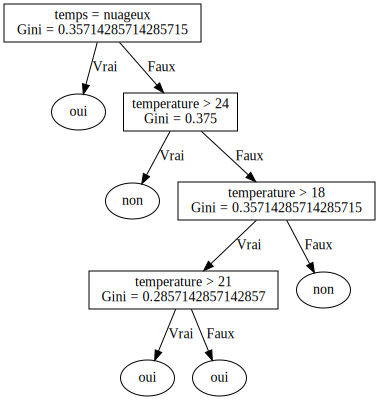

In [25]:
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph = Source(cart_classifieur.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

## IV- Comparison and analysis

### IV-1- Tree generation 

Here, we will compare ID3 and CART according to the tree generation. Reminder :
- ID3
    - uses the entropy 
    - the number of children is according to the number of values
- CART 
    - uses the Gini index
    - the number of threads is binary
    
Here, we will use the dataset "Play" with nominal values

In [26]:
id3_nom_classifieur = ID3()
id3_nom_classifieur.entrainer(X_jouer, Y_jouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")
print("ID3 :")
print(id3_nom_classifieur.code)

cart_nom_classifieur = CART()
cart_nom_classifieur.entrainer(X_jouer, Y_jouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")
print("CART :")
print(cart_nom_classifieur.code)

ID3 :
Si temps est "ensoleile" Alors
 Si humidite est "haute" Alors
  jouer est "non"
 Si humidite est "normale" Alors
  jouer est "oui"
Si temps est "nuageux" Alors
 jouer est "oui"
Si temps est "pluvieux" Alors
 Si vent est "non" Alors
  jouer est "oui"
 Si vent est "oui" Alors
  jouer est "non"

CART :
Si temps  est "nuageux" Alors
    jouer est "oui"
Sinon
    Si humidite  est "haute" Alors
        Si temps  est "ensoleile" Alors
            jouer est "non"
        Sinon
            jouer est "oui"
    Sinon
        Si vent  est "non" Alors
            jouer est "oui"
        Sinon
            jouer est "oui"



**<font color=red>Analysis</font>**: 

- For the generation of the tree, the choice of the node in ID3 is based on the calculation of the gain, and in CART it is based on the Gin divisor of the division, the attribute time being chosen as the root by both methods. The tree generated by the CART method is binary and gives rise to at least one leaf in each level, because the left subset is homogeneous, so we can make a decision. On the other hand, the tree generated by the ID3 method is a tree where each node has as many children as the values of the attribute assigned to it.

- For the CART method we set the depth to 3, that's why we had 3 levels, unlike the ID3 method where we didn't set the depth, but it's the stopping criterion that will make us stop when it's satisfied, (The stopping criterion is "the current node is pure", or, "Have a number of observations that is small". The tree generated by ID3 is faster.

- The two methods used the same characteristics but in different levels, and it comes back to the selection methods, we can say that the one used by CART noramlise the values, which gives a better presentation.

- The CART method can easily get rid of outliers.

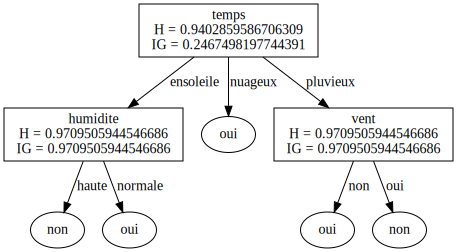

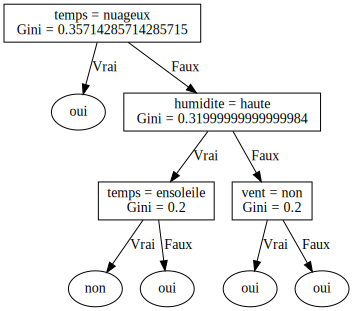

In [27]:
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph1 = Source(id3_nom_classifieur.graphviz())
    graph2 = Source(cart_nom_classifieur.graphviz())
    display(SVG(graph1.pipe(format='svg')), SVG(graph2.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

### IV-1- Types of attributes

Here, we will compare two CART classifiers applied on :
- nominal (categorical) data; already trained
- miscellaneous data (numerical and nominal)

In [28]:
print("CART with nominal characteristics:")
print("============================================")
print(cart_nom_classifieur.code)

print("")

cart_num_classifieur = CART()
cart_num_classifieur.entrainer(X_njouer, Y_njouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")

print("CART with some numerical characteristics:")
print("================================================")
print(cart_num_classifieur.code)

CART with nominal characteristics:
Si temps  est "nuageux" Alors
    jouer est "oui"
Sinon
    Si humidite  est "haute" Alors
        Si temps  est "ensoleile" Alors
            jouer est "non"
        Sinon
            jouer est "oui"
    Sinon
        Si vent  est "non" Alors
            jouer est "oui"
        Sinon
            jouer est "oui"


CART with some numerical characteristics:
Si temps  est "nuageux" Alors
    jouer est "oui"
Sinon
    Si temperature  > 24 Alors
        jouer est "non"
    Sinon
        Si temperature  > 18 Alors
            Si temperature  > 21 Alors
                jouer est "oui"
            Sinon
                jouer est "oui"
        Sinon
            jouer est "non"



**<font color=red>Analysis</font>**: 

- The depth of the tree does not change because it was previously set in the post condition of the pruning, 

- The characteristics used are different and this one comes back to the division method which is different.

- The trees have both the same type, they are both binary trees.

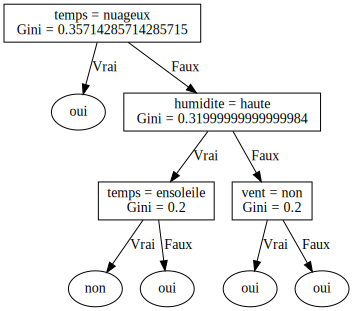

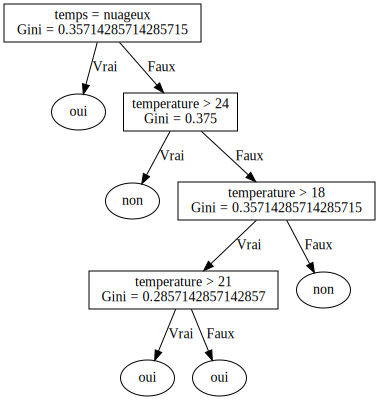

In [29]:
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph1 = Source(cart_nom_classifieur.graphviz())
    graph2 = Source(cart_num_classifieur.graphviz())
    display(SVG(graph1.pipe(format='svg')), SVG(graph2.pipe(format='svg')))

except ImportError:
    print("you need to install graphviz")

### IV-3- Performance

We will use [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) to classify flowers into three classes, using 4 features.

Three models will be used: 
- ID3 after discritization of the values
- CART 
- scikit-learn 

Description of the metrics: 
- the support is the number of samples
- for each class, we provide the precision, the recall and the F1-score
- micro avg : the metrics (precision, recall and F1-score) computed for the totality of the estimations (useful when the number of classes is unbalanced)
- macro avg : the metrics computed for each class, then averaged 
- weighted avg : the metrics computed for each class, multiplied by the equivalent support, summed, then divided by the total number of samples

In [30]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

iris = pd.read_csv("datasets/iris.csv")
iris = iris.sample(frac=1)
# Extraction des features 
X_iris = iris.iloc[:, :-1].values # Premières colonnes 

Y_iris = iris.iloc[:,-1].values # Dernière colonne 

X_names = list(iris.columns)[:-1]
Y_name = list(iris.columns)[-1]

# entrainnement
iris_msk = np.random.rand(len(X_iris)) < 0.8

X_iris_train = X_iris[iris_msk]
Y_iris_train = Y_iris[iris_msk]

X_iris_test = X_iris[~iris_msk]
Y_iris_test = Y_iris[~iris_msk]

iris.head()
#X_names, Y_name

,sepal_length,sepal_width,petal_length,petal_width,class
16,5.4,3.9,1.3,0.4,Iris-setosa
82,5.8,2.7,3.9,1.2,Iris-versicolor
87,6.3,2.3,4.4,1.3,Iris-versicolor
67,5.8,2.7,4.1,1.0,Iris-versicolor
6,4.6,3.4,1.4,0.3,Iris-setosa


In [31]:
# ID3 après discritisation 
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
est.fit(X_iris)
X_iris_disc = est.transform(X_iris)
X_iris_disc_train = X_iris_disc[iris_msk]
id3_iris = ID3()
id3_iris.entrainer(X_iris_disc_train, Y_iris_train, X_noms=X_names, Y_nom=Y_name, elagage=True)
X_iris_disc_test = X_iris_disc[~iris_msk]
id3_iris_res = id3_iris.predire(X_iris_disc_test)

# CART 
cart_iris = CART()
cart_iris.entrainer(X_iris_train, Y_iris_train, X_noms=X_names, Y_nom=Y_name)
cart_iris_res = cart_iris.predire(X_iris_test)

# sklearn
from sklearn.tree import DecisionTreeClassifier

sklearn_cart_iris = DecisionTreeClassifier()
sklearn_cart_iris.fit(X_iris_train, Y_iris_train)
sklearn_cart_iris_res = sklearn_cart_iris.predict(X_iris_test)


# Le rapport de classification
from sklearn.metrics import classification_report

print("ID3")
print(classification_report(Y_iris_test, id3_iris_res))


print("CART")
print(classification_report(Y_iris_test, cart_iris_res))

print("Scikit-learn")
print(classification_report(Y_iris_test, sklearn_cart_iris_res))

# Ignorer le warning

ID3
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       0.00      0.00      0.00        11
 Iris-virginica       0.45      1.00      0.62         9

       accuracy                           0.59        27
      macro avg       0.48      0.67      0.54        27
   weighted avg       0.41      0.59      0.47        27

CART
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       0.85      1.00      0.92        11
 Iris-virginica       1.00      0.78      0.88         9

       accuracy                           0.93        27
      macro avg       0.95      0.93      0.93        27
   weighted avg       0.94      0.93      0.92        27

Scikit-learn
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       0.85      1.00      0.92        11
 I

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**<font color=red>Analysis</font>**: 

- **ID3**: Precision varies between 55% and 100%, it is the lowest among the 3 models, Recall is always good, f1 score varies between 71% and 100% 

- **CART**: The precision varies between 90% and 100%, it is the best between the 3 models, Also for the recall, and the f1 score is always above 95% is the best between the 3models.

- Scikit-learn**: The precision varies between 75 and 100%, it is less than that of CART but good compared to ID3, the recall and the f1 score are also good. 